# Optimization of the spatial profile

Idea:
 - The goal is to extract a flux, reproject it on the detector and determine a correction on the spatial profile using this projection
 - For a given pixel, we don't know to which order the correction corresponds, so we assume that the correction is proportional to the previous estimate of the spatial profile of each order.
 - We also assume that the correction we want to bring is a fraction of the estimate of the error. This is know as a fixed point iteration method

Definitions:
 - $P_i$: Real spatial profile at order $i$
 - $P^{(j)}_i$: $j$ th estimate of the spatial profile at order $i$
 - $\epsilon^{(j)}_i$ estimate of the error of $P^{(j)}_i$ compared to $P_i$, so that $\epsilon^{(j)}_i = P_i - P^{(j)}_i$
 - $E^{(n)}$: Relative error of the rebuilt detector (compared to the data). Given by the equation: (detector - rebuilt) / rebuilt
 - $\alpha$: scale factor

Description: <br>
If we assume that the error $\epsilon^{(j)}_i$ at a given pixel is proportional to the spatial profile estimate of each order ($P^{(j)}_i$), we can demonstrate that
\begin{equation}
\epsilon^{(j)}_1 = \frac{P^{(j)}_1}{P^{(j)}_2} \epsilon^{(j)}_2 ,
\end{equation}
assuming we have 2 orders.

Then, if we assume that a pixel (or the detector) can be modeled as

\begin{equation}
M^{(j)} = (P^{(j)}_1 + \epsilon^{(j)}_1) \int_1 (...) d\lambda \, + \,\, (P^{(j)}_2 + \epsilon^{(j)}_2) \int_2 (...) d\lambda  ,
\end{equation}
we can conclude that
\begin{equation}
\epsilon^{(j)}_i = P^{(j)}_i E^{(j)}
\end{equation}

Finally, the next estimate of $P_i$ will be given by $P^{(j+1)}_i = P^{(j)}_i + \alpha \epsilon^{(j)}_i = P^{(j)}_i + \alpha P^{(j)}_i E^{(j)}$.

Convergence:
- This has the form $g(P_i) = P_i + \alpha f(P_i)$ and we are looking to find $P_i^*$ such that $g(P_i^*) = P_i^*$. That is the definition of a **fixed point**.
- A typical stopping criterion is to require that
\begin{equation}
    \frac{|P_i^{(j+1)} - P_i^{(j)}|}{max(P_i^{(j)}, \xi)} < tol_i
\end{equation}
where $\xi$ ensures that the criterion does not diverge if $P_i$ is close to zero. $tol_i$ is the relative tolerance of a given pixel. The relative error map could be used.



## Imports

In [1]:
# Import standard packages.
import numpy as np
from astropy.io import fits

# Imports from the extraction.
from extract.overlap import TrpzOverlap
from extract.throughput import ThroughputSOSS
from extract.convolution import WebbKer

# Imports for plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # For displaying of FITS images.
# TODO astropy has some nice functions for colorbars scaling of astronomical data, might be worth looking into.

### Matplotlib defaults

In [2]:
%matplotlib inline

In [3]:
plt.rc('figure', figsize=(13,8)) 
plt.rc('font', size=16)
plt.rc('image', cmap='inferno')
plt.rc('lines', lw=2)

## Read some ref files

In [4]:
# Read relevant files TODO maybe we could make a a function that does this in utils?
# ANSWER : Yes, should we do it with the spacetel framework (so not now)?

# List of orders to consider in the extraction
order_list = [1, 2]

#### Wavelength solution ####
wave_maps = []
wave_maps.append(fits.getdata("extract/Ref_files/wavelengths_m1.fits"))
wave_maps.append(fits.getdata("extract/Ref_files/wavelengths_m2.fits"))

#### Spatial profiles ####
spat_pros = []
spat_pros.append(fits.getdata("extract/Ref_files/spat_profile_m1.fits").squeeze())
spat_pros.append(fits.getdata("extract/Ref_files/spat_profile_m2.fits").squeeze())

# Convert data from fits files to float (fits precision is 1e-8)
wave_maps = [wv.astype('float64') for wv in wave_maps]
spat_pros = [p_ord.astype('float64') for p_ord in spat_pros]

#### Throughputs ####
thrpt_list = [ThroughputSOSS(order) for order in order_list]

#### Convolution kernels ####
ker_list = [WebbKer(wv_map) for wv_map in wave_maps]

# Put all inputs from reference files in a list
ref_files_args = [spat_pros, wave_maps, thrpt_list, ker_list]

## Load simulation

In [5]:
# Import custom function to read toy simulation
from sys import path  # TODO all import should be at the top. 
# Answer: this is temporary since we should have better simulations eventually
#         and my format was very custom. That's why I let this whole section
#         in a separate bloc.
path.append("Fake_data")
from simu_utils import load_simu  # TODO can this function be moved to utils?
# Answer: same as previous comment: very custom format. Should be changed.
# Load a simulation
simu = load_simu("../../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5.fits")
data = simu["data"]

## Extraction

### Extraction Parameters
(Example usage with few inputs parameters.)

In [22]:
params = {}

# Map of expected noise (standard deviation).
bkgd_noise = 20.  # In counts?

# Wavelength extraction grid oversampling.
params["n_os"] = 2  # TODO explain a bit more how the grid is determined?
# Answer: I was thinking of explaining all inputs in another notebook or text?
#         Since this parameter is needed for every extraction, I didn't want
#         to re-explain it in all examples. What do you think?

# Threshold on the spatial profile. 
# Only pixels above this threshold will be used for extraction.
# (for at least one order)
params["thresh"] = 1e-4  # Same units as the spatial profiles

### Initiate extraction object
(This needs to be done only once unless the oversampling (`n_os`) changes.)

In [27]:
extract = TrpzOverlap(*ref_files_args, c_kwargs={'thresh':1e-6}, **params)

### Find the best tikhonov factor
This takes some time, so it's better to do it once if the exposures are part of a time series observation, i.e. observations of the same object at similar SNR.

Testing factors...
14/14


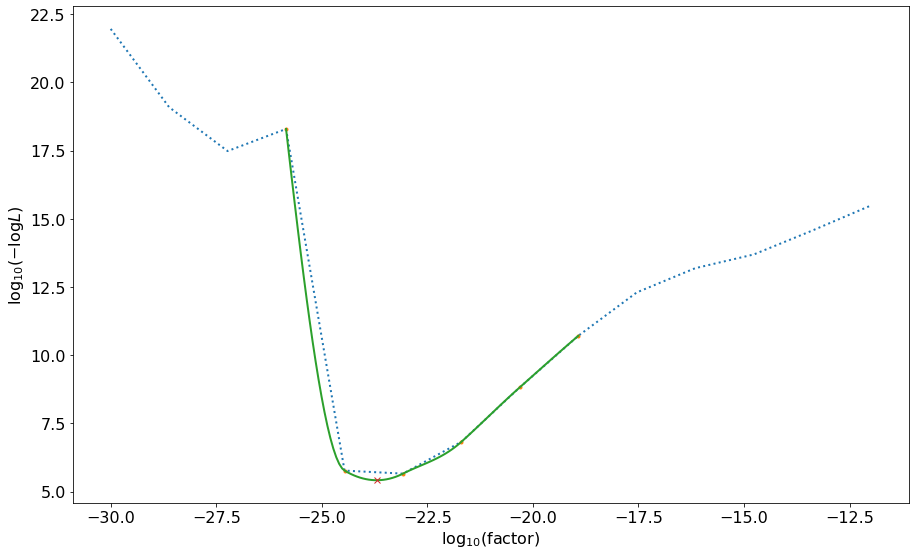

In [8]:
# Determine which factors to tests.
factors = np.logspace(-30, -12, 14)

# Noise estimate to weigh the pixels.
# Poisson noise + background noise.
sig = np.sqrt(data + bkgd_noise**2)

# Tests all these factors.
tests = extract.get_tikho_tests(factors, data=data, sig=sig)  # TODO sig is the uncertainty on the date here so it might be good to call it that?

# Find the best factor.
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

Testing factors...
20/20


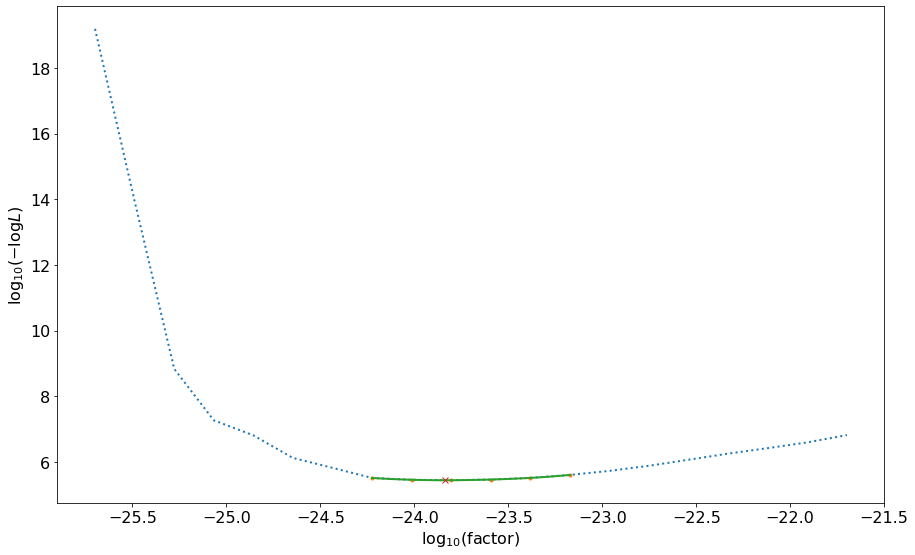

In [9]:
# Refine the grid (span 4 orders of magnitude).
best_fac = np.log10(best_fac)
factors = np.logspace(best_fac-2, best_fac+2, 20)

# No need to specify `data` and `sig` again. 
# TODO: why not? Wouldn't it be better to require that to avoid confusion?
# Answer: When a reference file or science file is specified, the class keeps it
#         as an attribute. When an extraction is called, it is updated if specified.
#         It is done to save some text when iterating on the spatial profile, for
#         example, and to save time (some matrix multiplications don't need to be 
#         re-computed). But I'm open to discuss it!
tests = extract.get_tikho_tests(factors, data=data, sig=sig)
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

### Compare result to injected spectrum

In [30]:
simu

{'grid': array([0.55028933, 0.5503206 , 0.55035187, ..., 2.99896924, 2.99903714,
        2.99910505]),
 'f_k': array([4.72029320e+17, 4.71761943e+17, 4.71523937e+17, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'grid_c1': array([0.83615988, 0.83619105, 0.83622223, ..., 2.83632606, 2.83639357,
        2.83646109]),
 'f_c1': array([1.27513409e+17, 1.27493226e+17, 1.27473109e+17, ...,
        2.24926315e+15, 2.24904694e+15, 2.24883060e+15]),
 'grid_c2': array([0.5529112 , 0.55294192, 0.55297263, ..., 1.41168005, 1.4117111 ,
        1.41176256]),
 'f_c2': array([4.64368361e+17, 4.64324848e+17, 4.64286324e+17, ...,
        2.77874001e+16, 2.77850474e+16, 2.77812351e+16]),
 'data': array([[ 14.10512256,  -3.95967257,  10.52447484, ..., -14.13736113,
         -20.94488784,  15.26676589],
        [-17.11189848, -14.48966492,  -2.6145901 , ...,  -1.57250597,
           6.15776183,  -0.287649  ],
        [-23.88106705, -26.1715474 ,   0.77425164, ..., -12.09461067,
         -1

In [28]:
# f_k = extract(data=data, sig=sig, p_list=spat_pros, tikhonov=True, factor=best_fac)
f_k = extract(data=data, sig=sig, p_list=spat_pros)

In [29]:
rebuilt = extract.rebuild(f_k)

In [15]:
%matplotlib notebook

In [31]:
plt.plot?

<IPython.core.display.Javascript object>


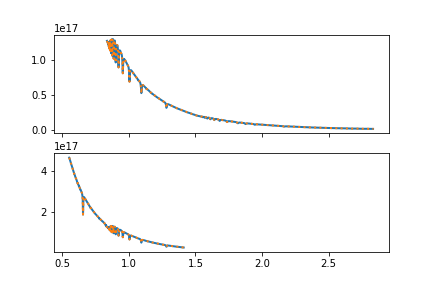

In [16]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(extract.lam_grid_c(0), extract.c_list[0].dot(f_k))
ax[0].plot('grid_c1', 'f_c1', ":", data=simu)

ax[1].plot(extract.lam_grid_c(1), extract.c_list[1].dot(f_k))
ax[1].plot('grid_c2', 'f_c2', ":", data=simu)

In [45]:
plt.pcolormesh?

In [66]:
from scipy.interpolate import interp1d

In [72]:
extract.bin_to_pixel?

<IPython.core.display.Javascript object>


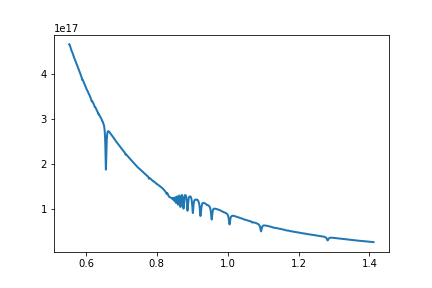

In [17]:
# plt.plot(extract.lam_grid_c(1), extract.c_list[1].dot(f_k))
plt.plot(simu['grid_c2'], simu['f_c2'])

<IPython.core.display.Javascript object>


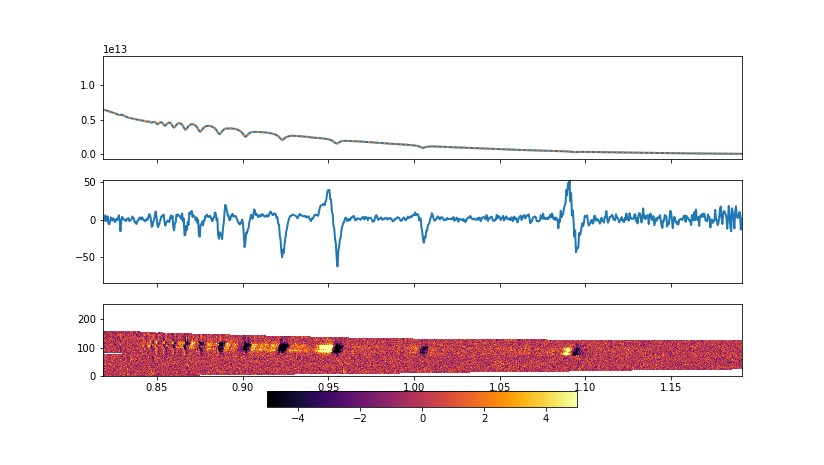

In [30]:
fig, ax = plt.subplots(3, 1, sharex=True)

grid_bin, f_bin = extract.bin_to_pixel(f_k_c=extract.c_list[1].dot(f_k),
                                       grid_pix=wave_maps[1][100,:1800],
                                       grid_f_k=extract.lam_grid_c(1), i_ord=1)
_, f_bin_th = extract.bin_to_pixel(f_k_c=simu['f_c2'], grid_pix=grid_bin, grid_f_k=simu['grid_c2'], i_ord=1)

ax[0].plot(grid_bin, f_bin)
ax[0].plot(grid_bin, f_bin_th, ":")

# f_th_interp = interp1d(simu['grid_c2'], simu['f_c2'], kind='cubic', bounds_error=False, fill_value=np.nan)
ax[1].plot(grid_bin, (f_bin-f_bin_th)/f_bin_th*1e6)

im = ax[-1].pcolormesh(wave_maps[1][100,:1800], np.arange(256), ((rebuilt-data)/sig)[:, :1800], vmin=-5, vmax=5)
# plt.imshow((rebuilt-data)/sig, vmin=-5, vmax=5., interpolation=None)
plt.colorbar(im, ax=ax[-1], orientation="horizontal")

<IPython.core.display.Javascript object>


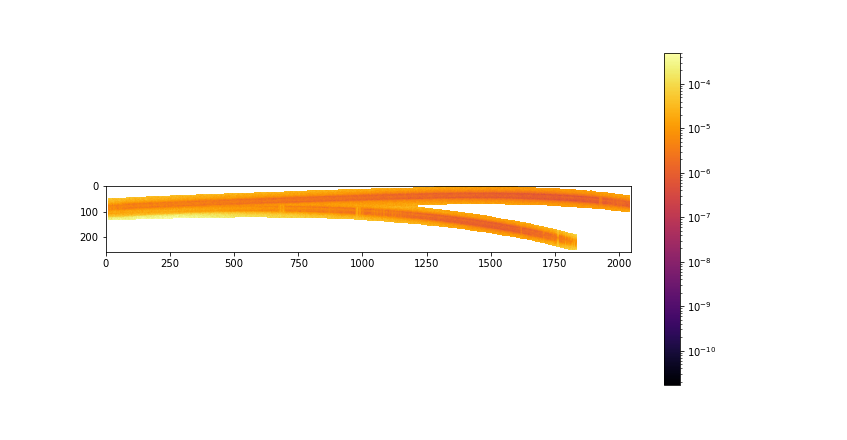

In [37]:
plt.figure()
plt.imshow(np.abs(rebuilt-data)/data, vmax=0.5e-3, norm=LogNorm(), interpolation=None)
plt.colorbar()

### Optimize the spatial profiles

In [23]:
import time

In [11]:
def optimize_profile(self, f_k=None, min_val=1e-3, rtol_map=None,
                     scale_factor=0.1, max_iter=50, n_sample=10, max_sample=20, **kwargs):
    
    # Use object error map to generate a relative
    # error map if `rtol_map` not given
    if rtol_map is None:
        rtol_map = 3 * self.sig / self.data
        
    # extract f_k if not given
    if f_k is None:
        f_k = self(**kwargs)
    
    # Get spatial profiles from object
    p_list = np.array(self.p_list)
    # Save total spatial profile for each column.
    # It should be ~equal to 1, unless the trace goes
    # out of the detector.
    p_tot = np.nansum(p_list, axis=1)
    
    # Iterate
    p_save = []
    # Masked pixels are considered converged
    # TODO: use real mask, deal with normalisation and masks.
    pix_converged = np.isnan(p_list)
    p_sum = np.zeros(p_list.shape, dtype=float)
    n_p_sum = np.zeros(p_list.shape, dtype=int)
    converged = False
    i_sample = 0
    
    fig = plt.figure(figsize=(12,12))
    N = 6
    cycler = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
    colors = cycler.by_key()['color']
    plt.plot((rtol_map*p_list[0])[50:130, 600], "k--", alpha=0.4)
    plt.plot((rtol_map*p_list[1])[50:130, 600], "k", alpha=0.4)
    
    for i in range(max_iter):
        # Get relative error
        rel_err = get_rel_err(self, f_k)

        # Weigh the error depending on the order contribution at each pixel
        # The result is the absolute (not relative) error for each orders
        p_error = rel_err * p_list
        
        # Test convergence
        # Define criterion
        denominator = np.clip(np.abs(p_list), min_val, None)
        criterion = (np.abs(p_error) / denominator)
        # Convert to masked array
        criterion = np.ma.masked_invalid(criterion)
        # Update map of converged pixels
        pix_converged[criterion < rtol_map] = True
        # Check global convergence
        if converged or pix_converged.all():
            # State convergence
            converged = True
            # Make `n_sample` iteration after convergence
            i_sample += 1
            print("Converged.", i_sample, "/", n_sample)
        else:
            print(i, ", mean rel error: ", criterion.mean(),
                  ", not converged: ", (~pix_converged).sum())        
        
        # Correct p_list with scaled correction
        p_list = p_list + p_error * scale_factor
        
        # Enforce normalization
        norm = np.divide(np.nansum(p_list, axis=1), p_tot,
                         out=np.zeros_like(p_tot), where=p_tot!=0)[:, None, :]
        p_list = np.divide(p_list, norm, out=np.zeros_like(p_list), where=norm!=0)
        
        # Save value of converged pixels to make stats
        if pix_converged.any():
            p_to_save = np.ones_like(p_list) * np.nan
            p_to_save[pix_converged] = p_list[pix_converged]
            # Make sure p_save does not exceed `max_sample`
            p_save = p_save[-(max_sample - 1):]
            # Append
            p_save.append(p_to_save)
            # Take mean for converged pixels
            p_sum[pix_converged] += p_list[pix_converged]
            n_p_sum[pix_converged] += 1
            p_list[pix_converged] = p_sum[pix_converged]
            p_list[pix_converged] /= n_p_sum[pix_converged]
            if (n_p_sum[pix_converged] <= 0).any():
                print('weird')
            
        # Plot a slice of the spatial profile
        plt.plot(p_error[0, 50:130, 600], color=colors[i%N], linestyle="--")
        plt.plot(p_error[1, 50:130, 600], color=colors[i%N])
        fig.canvas.draw()
        time.sleep(1)

        # Stop when `n_sample` iteration after convergence
        if i_sample == n_sample:
            break
            
        # Re-extract
        f_k = self(p_list=p_list, **kwargs)

    else:
        print("*** Not converged: Reached max iteration ***")
        
    plt.show()
    return np.array(p_save)
    
def get_rel_err(self, f_k):
    """
    Return the relative error of the rebuilt detector image.
    """
    # Define an error map
    rebuilt = self.rebuild(f_k)
    rel_err = (self.data - rebuilt) / rebuilt

    return rel_err


<IPython.core.display.Javascript object>


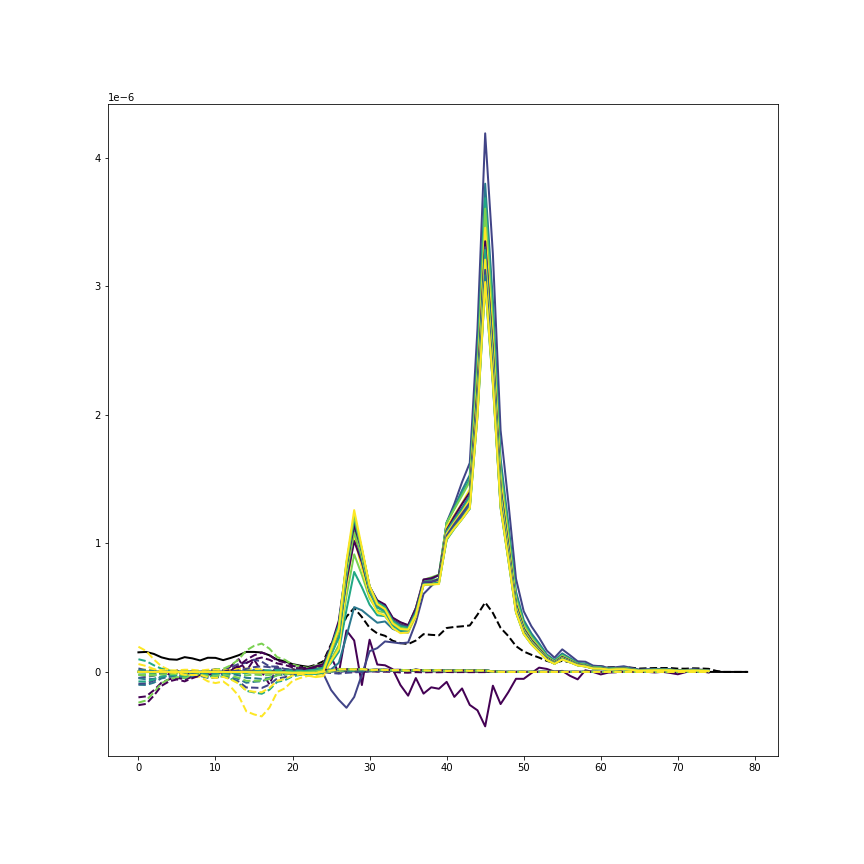

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


0 , mean rel error:  2.6732089677232942e-06 , not converged:  581486


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


1 , mean rel error:  0.0001057644240925855 , not converged:  576697


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


2 , mean rel error:  5.622467333239792e-05 , not converged:  573545


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


3 , mean rel error:  5.130153647737674e-05 , not converged:  572289


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


4 , mean rel error:  4.8991352283001374e-05 , not converged:  571787


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


5 , mean rel error:  4.7443330046151975e-05 , not converged:  571456


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


6 , mean rel error:  4.702769756243907e-05 , not converged:  571242


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


7 , mean rel error:  4.674545986488913e-05 , not converged:  571072


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


8 , mean rel error:  4.569498880572879e-05 , not converged:  570961


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


9 , mean rel error:  4.542632956866631e-05 , not converged:  570860


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


10 , mean rel error:  4.554251389420559e-05 , not converged:  570783


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


11 , mean rel error:  4.501157641540361e-05 , not converged:  570744


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


12 , mean rel error:  4.5256281647043315e-05 , not converged:  570715


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


13 , mean rel error:  4.4885008849732614e-05 , not converged:  570682


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


14 , mean rel error:  4.4646730268961614e-05 , not converged:  570666


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


15 , mean rel error:  4.461760959960923e-05 , not converged:  570641


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


16 , mean rel error:  4.5208717122294915e-05 , not converged:  570633


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


17 , mean rel error:  4.494457529667827e-05 , not converged:  570622


KeyboardInterrupt: 

In [61]:
spat_pros_estimates = optimize_profile(extract, f_k=f_k, tikhonov=True, factor=best_fac, scale_factor=0.8)

In [62]:
plt.close()

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


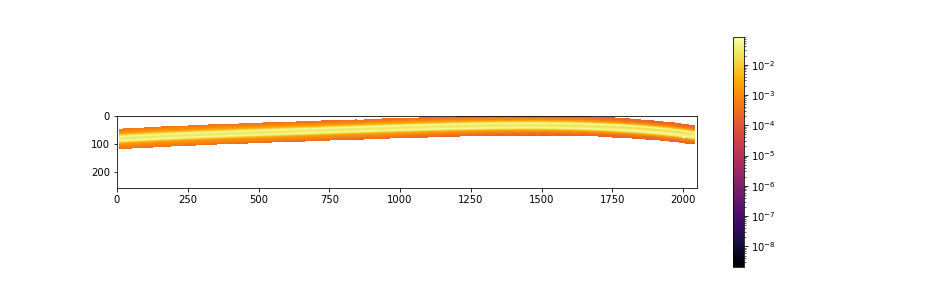

In [146]:
plt.imshow(np.nanmean(spat_pros_estimates, axis=0)[0], norm=LogNorm())
plt.colorbar()

<IPython.core.display.Javascript object>


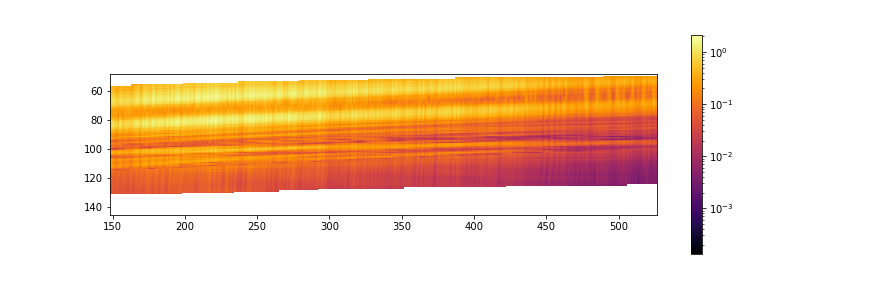

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [148]:
plt.figure()
plt.imshow((np.nanstd(spat_pros_estimates, axis=0)[1]/np.nanmean(spat_pros_estimates, axis=0)[1]/sig*data), norm=LogNorm())
plt.colorbar()

In [63]:
# f_k = extract(data=data, sig=sig, tikhonov=True, factor=best_fac)
f_k = extract(data=data, sig=sig)

In [64]:
rebuilt = extract.rebuild(f_k)
rel_err = (extract.data - rebuilt) / rebuilt

<IPython.core.display.Javascript object>


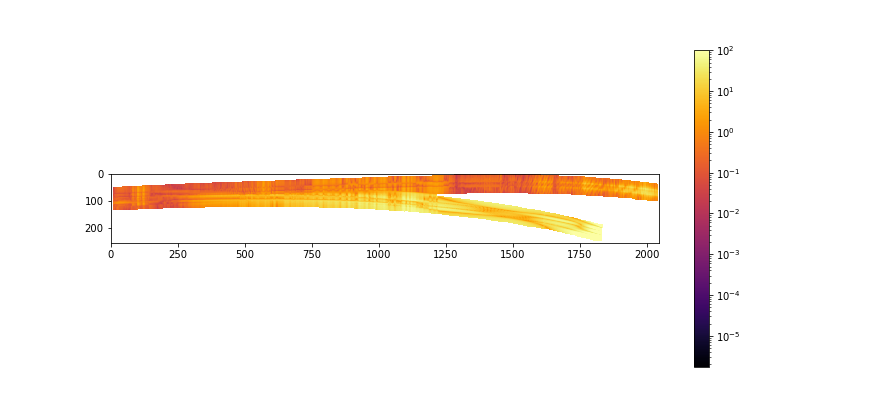

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [66]:
plt.figure()
plt.imshow(np.abs(rebuilt-data)/np.sqrt(data), norm=LogNorm(), vmax=1e2, interpolation=None)
plt.colorbar()

<IPython.core.display.Javascript object>


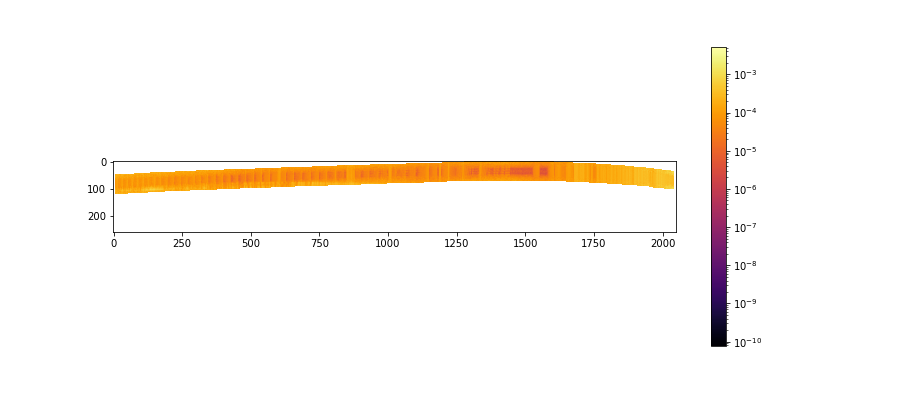

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [133]:
plt.figure()
plt.imshow(np.abs(spat_pros[0]-extract.p_list[0])/spat_pros[0], norm=LogNorm())
plt.colorbar()

<IPython.core.display.Javascript object>


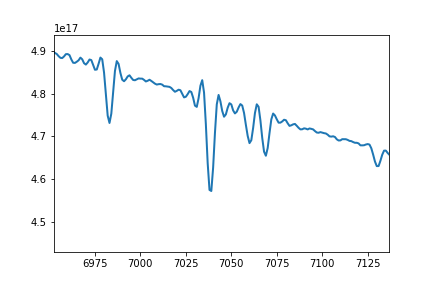

In [54]:
plt.plot(f_k)

In [53]:
plt.close()